In [25]:
#Library import
import numpy as np
import pandas as pd
import kaggle.cli
import tensorflow as tf
import sys
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.mixed_precision import Policy
from sklearn import preprocessing
from pathlib import Path
from zipfile import ZipFile
from IPython.display import display, HTML


In [26]:
def historyOut(history):
    print(history.history.keys())
# "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    print('Average MSE: ',sum(history.history['mse'])/len(history.history['mse']))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [27]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')


tf.config.experimental.get_memory_growth(physical_device[0])

tf.config.experimental.set_memory_growth(physical_device[0],True)


tf.config.experimental.get_memory_growth(physical_device[0])

Num GPUs Available:  1
Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [28]:


policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

"""INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has 
compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5"""

'INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK\nYour GPU will likely run quickly with dtype policy mixed_float16 as it has \ncompute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5'

In [29]:
#Uncomment this for submission

!kaggle datasets download -d austinreese/craigslist-carstrucks-data

file_name = 'craigslist-carstrucks-data.zip' # dataset name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')
    
data_A = pd.read_csv('vehicles.csv') # file name
print(data_A.shape)
print(data_A.count())


"\n!kaggle datasets download -d austinreese/craigslist-carstrucks-data\n\nfile_name = 'craigslist-carstrucks-data.zip' # dataset name\nwith ZipFile(file_name, 'r') as zip:\n  zip.extractall()\n  print('Done')\n    \ndata_A = pd.read_csv('vehicles.csv') # file name\nprint(data_A.shape)\nprint(data_A.count())\n"

In [44]:
#Delete this before submission
"""
data_A = pd.read_csv('C:/Users/Gabriel/Downloads/vehicles.csv') # file name
print(data_A.shape)
print(data_A.count())
"""

(426880, 26)
id              426880
url             426880
region          426880
region_url      426880
price           426880
year            425675
manufacturer    409234
model           421603
condition       252776
cylinders       249202
fuel            423867
odometer        422480
title_status    418638
transmission    424324
VIN             265838
drive           296313
size            120519
type            334022
paint_color     296677
image_url       426812
description     426810
county               0
state           426880
lat             420331
long            420331
posting_date    426812
dtype: int64


In [45]:

drop = {'id', 'url', 'size','cylinders','region_url', 'image_url', 'county', 'posting_date', 
        'description', 'title_status','VIN','lat','long'}

for field in drop:
    if field in data_A.columns:
        data_A = data_A.drop(field,1)

data_A = data_A.dropna()

print(data_A.isnull().sum()) # see what is missing from data
print(data_A.count())

data_A.info()

C:\Users\Gabriel\AppData\Local\Temp/ipykernel_10660/2996476342.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_A = data_A.drop(field,1)


region          0
price           0
year            0
manufacturer    0
model           0
condition       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
state           0
dtype: int64
region          163406
price           163406
year            163406
manufacturer    163406
model           163406
condition       163406
fuel            163406
odometer        163406
transmission    163406
drive           163406
type            163406
state           163406
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 163406 entries, 31 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        163406 non-null  object 
 1   price         163406 non-null  int64  
 2   year          163406 non-null  float64
 3   manufacturer  163406 non-null  object 
 4   model         163406 non-null  object 
 5   condition     163406 non-null  object 
 6   fuel         

In [46]:
catgFeatures = ['region', 'manufacturer', 'model', 'condition', 
                 'fuel', 'odometer', 'transmission', 
                'drive', 'type', 'paint_color', 'state',
               ]
                #add back to incldue size: 'size',]

#Categorical variable encoding
for feature in catgFeatures:
    featureData = data_A[feature]
    featuresEncoded = LabelEncoder().fit_transform(featureData)
    data_A[feature] = featuresEncoded
    
#featureCorrelation = data_A.corr()
#sns.heatmap(featureCorrelation, annot=False, vmin=-1, vmax=1, center=0)

In [47]:
data_A = data_A.sample(frac=1)
X = data_A.values
y = data_A['price'].values.reshape(-1,1)

print(data_A.head())


scaler_x = MinMaxScaler()
print(scaler_x.fit(X))
scaler_y = MinMaxScaler()
print(scaler_y.fit(y))
xscale=scaler_x.transform(X)
yscale=scaler_y.transform(y)


        region  price    year  manufacturer  model  condition  fuel  odometer  \
356317     173  28590  2017.0            10   3102          2     4     15192   
332485     268  26990  2017.0            30  12089          2     2      9628   
195399      49  39590  2020.0            13   8658          2     2       415   
329924     135   5900  2012.0             7   3929          2     2     23017   
204758     163  40990  2018.0            20  12994          2     2      6016   

        transmission  drive  type  state  
356317             2      2     3     42  
332485             2      0     8     38  
195399             2      2     3     22  
329924             0      1     9     38  
204758             2      0     0     22  
MinMaxScaler()
MinMaxScaler()


In [48]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

#### Model 1: Activation = ReLU, Hidden Layers: 1(24 units), 2(32 units)

In [36]:
#Activation: ReLU
model = Sequential()
model.add(Dense(24, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                336       
                                                                 
 dense_7 (Dense)             (None, 32)                800       
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [37]:
#ReLU
#LEARNING RATE 0.01
rms = keras.optimizers.RMSprop(learning_rate=0.00001)

model.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])

In [38]:
history = model.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

Epoch 1/2
334/334 [==============================] - 2s 5ms/step - loss: 4.6565e-04 - mse: 4.6572e-04 - mae: 0.0166 - acc: 0.0445 - val_loss: 1.7196e-04 - val_mse: 1.7196e-04 - val_mae: 0.0108 - val_acc: 0.0456
Epoch 2/2
334/334 [==============================] - 1s 4ms/step - loss: 1.1927e-04 - mse: 1.1925e-04 - mae: 0.0084 - acc: 0.0445 - val_loss: 6.3242e-05 - val_mse: 6.3245e-05 - val_mae: 0.0065 - val_acc: 0.0456


dict_keys(['loss', 'mse', 'mae', 'acc', 'val_loss', 'val_mse', 'val_mae', 'val_acc'])


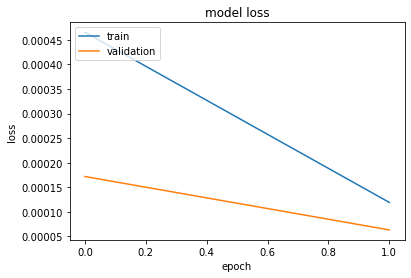

Average MSE:  0.00029248238570289686


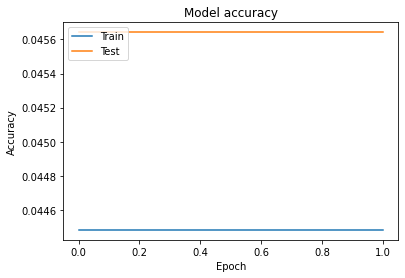

In [39]:
historyOut(history)

In [15]:
#ReLU
#LEARNING RATE 0.001
rms = keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

Epoch 1/50
334/334 [==============================] - 2s 5ms/step - loss: 1.1028e-05 - mse: 1.1027e-05 - mae: 0.0025 - acc: 0.0445 - val_loss: 6.5259e-07 - val_mse: 6.5312e-07 - val_mae: 7.4717e-04 - val_acc: 0.0469
Epoch 2/50
334/334 [==============================] - 1s 4ms/step - loss: 4.9686e-07 - mse: 4.9785e-07 - mae: 6.8418e-04 - acc: 0.0445 - val_loss: 4.0702e-07 - val_mse: 4.1942e-07 - val_mae: 6.0902e-04 - val_acc: 0.0469
Epoch 3/50
334/334 [==============================] - 1s 4ms/step - loss: 3.6908e-07 - mse: 3.6296e-07 - mae: 5.9052e-04 - acc: 0.0445 - val_loss: 4.0702e-07 - val_mse: 4.0733e-07 - val_mae: 5.9977e-04 - val_acc: 0.0469
Epoch 4/50
334/334 [==============================] - 1s 4ms/step - loss: 3.2683e-07 - mse: 3.3315e-07 - mae: 5.6533e-04 - acc: 0.0445 - val_loss: 3.4741e-07 - val_mse: 3.4593e-07 - val_mae: 5.4590e-04 - val_acc: 0.0469
Epoch 5/50
334/334 [==============================] - 1s 4ms/step - loss: 3.0946e-07 - mse: 3.0378e-07 - mae: 5.3868e-04 - a

dict_keys(['loss', 'mse', 'mae', 'acc', 'val_loss', 'val_mse', 'val_mae', 'val_acc'])


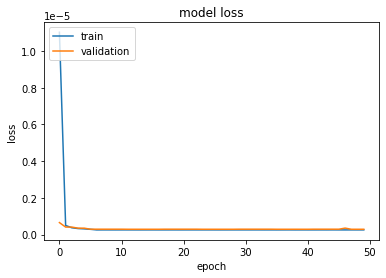

Average MSE:  4.874224094919555e-07


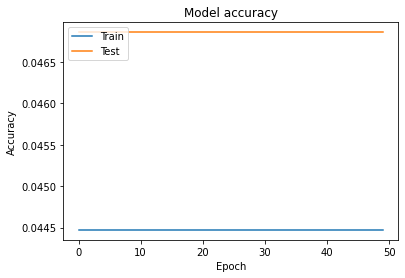

In [16]:
historyOut(history)

In [17]:
#ReLU
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

Epoch 1/50
334/334 [==============================] - 2s 5ms/step - loss: 1.4137e-08 - mse: 1.6229e-08 - mae: 4.5407e-05 - acc: 0.0445 - val_loss: 5.0820e-08 - val_mse: 5.3772e-08 - val_mae: 5.3445e-05 - val_acc: 0.0469
Epoch 2/50
334/334 [==============================] - 2s 4ms/step - loss: 1.3242e-08 - mse: 1.5590e-08 - mae: 4.7227e-05 - acc: 0.0445 - val_loss: 5.0820e-08 - val_mse: 5.3695e-08 - val_mae: 5.2671e-05 - val_acc: 0.0469
Epoch 3/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5582e-08 - mae: 4.7532e-05 - acc: 0.0445 - val_loss: 5.0820e-08 - val_mse: 5.4087e-08 - val_mae: 5.6485e-05 - val_acc: 0.0469
Epoch 4/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5599e-08 - mae: 4.7908e-05 - acc: 0.0445 - val_loss: 5.0820e-08 - val_mse: 5.3654e-08 - val_mae: 5.2253e-05 - val_acc: 0.0469
Epoch 5/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5581e-08 - mae: 4.7148e-05

dict_keys(['loss', 'mse', 'mae', 'acc', 'val_loss', 'val_mse', 'val_mae', 'val_acc'])


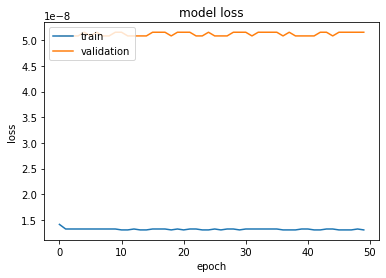

Average MSE:  1.558265179113505e-08


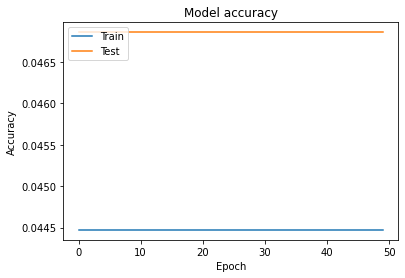

In [18]:
historyOut(history)

## Model 2: Activation = tanh, Hidden Layers: 1(24 units), 2(32 units)

In [19]:
#Activation: tanh
model2 = Sequential()
model2.add(Dense(24, input_dim=13, kernel_initializer='normal', activation='tanh'))
model2.add(Dense(32, activation='tanh'))
model2.add(Dense(1, activation='linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                168       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [20]:
#tanh
#LEARNING RATE =  0.01
rms = keras.optimizers.RMSprop(learning_rate=0.01)

model2.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model2.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

Epoch 1/50
334/334 [==============================] - 2s 5ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0231 - acc: 0.0445 - val_loss: 2.4135e-05 - val_mse: 2.4138e-05 - val_mae: 0.0042 - val_acc: 0.0469
Epoch 2/50
334/334 [==============================] - 1s 4ms/step - loss: 4.1843e-04 - mse: 4.1844e-04 - mae: 0.0115 - acc: 0.0445 - val_loss: 7.3138e-06 - val_mse: 7.3116e-06 - val_mae: 0.0021 - val_acc: 0.0469
Epoch 3/50
334/334 [==============================] - 1s 4ms/step - loss: 1.6728e-04 - mse: 1.6730e-04 - mae: 0.0067 - acc: 0.0445 - val_loss: 1.7294e-04 - val_mse: 1.7296e-04 - val_mae: 0.0131 - val_acc: 0.0469
Epoch 4/50
334/334 [==============================] - 1s 4ms/step - loss: 8.0054e-05 - mse: 8.0054e-05 - mae: 0.0051 - acc: 0.0445 - val_loss: 2.8781e-07 - val_mse: 2.8109e-07 - val_mae: 4.6447e-04 - val_acc: 0.0469
Epoch 5/50
334/334 [==============================] - 1s 4ms/step - loss: 4.8107e-05 - mse: 4.8109e-05 - mae: 0.0042 - acc: 0.0445 - val_loss: 5.4399e-08 - 

dict_keys(['loss', 'mse', 'mae', 'acc', 'val_loss', 'val_mse', 'val_mae', 'val_acc'])


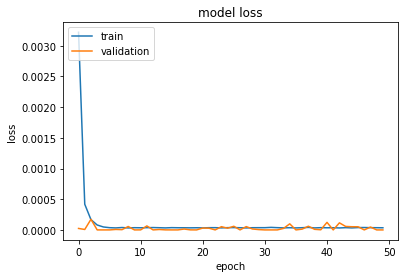

Average MSE:  0.00011083565877925138


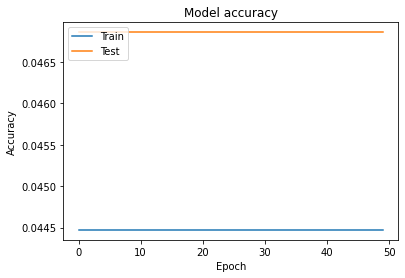

In [21]:
historyOut(history)

In [22]:
#tanh
#LEARNING RATE =  0.001
rms = keras.optimizers.RMSprop(learning_rate=0.001)

model2.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model2.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

Epoch 1/50
334/334 [==============================] - 2s 5ms/step - loss: 3.6262e-07 - mse: 3.6438e-07 - mae: 5.3231e-04 - acc: 0.0445 - val_loss: 3.5099e-07 - val_mse: 3.5910e-07 - val_mae: 5.5483e-04 - val_acc: 0.0469
Epoch 2/50
334/334 [==============================] - 1s 4ms/step - loss: 2.7209e-07 - mse: 2.6555e-07 - mae: 5.0181e-04 - acc: 0.0445 - val_loss: 4.1059e-07 - val_mse: 3.9686e-07 - val_mae: 5.8781e-04 - val_acc: 0.0469
Epoch 3/50
334/334 [==============================] - 1s 4ms/step - loss: 2.7081e-07 - mse: 2.6632e-07 - mae: 5.0173e-04 - acc: 0.0445 - val_loss: 2.9139e-07 - val_mse: 3.0590e-07 - val_mae: 5.0463e-04 - val_acc: 0.0469
Epoch 4/50
334/334 [==============================] - 1s 4ms/step - loss: 2.7152e-07 - mse: 2.6545e-07 - mae: 5.0168e-04 - acc: 0.0445 - val_loss: 2.9139e-07 - val_mse: 3.0964e-07 - val_mae: 5.0831e-04 - val_acc: 0.0469
Epoch 5/50
334/334 [==============================] - 1s 4ms/step - loss: 2.7206e-07 - mse: 2.6646e-07 - mae: 5.0206e-04

dict_keys(['loss', 'mse', 'mae', 'acc', 'val_loss', 'val_mse', 'val_mae', 'val_acc'])


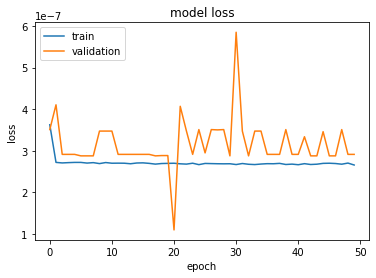

Average MSE:  2.6715404999322345e-07


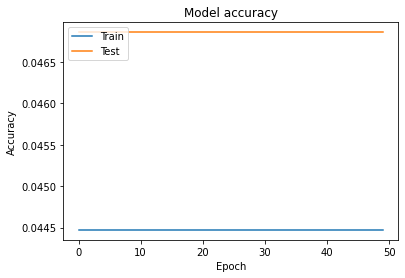

In [23]:
historyOut(history)

In [24]:
#tanh
#LEARNING RATE =  0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model2.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model2.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

Epoch 1/50
334/334 [==============================] - 2s 5ms/step - loss: 1.4137e-08 - mse: 1.6311e-08 - mae: 4.5259e-05 - acc: 0.0445 - val_loss: 5.1535e-08 - val_mse: 5.3781e-08 - val_mae: 5.0452e-05 - val_acc: 0.0469
Epoch 2/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5589e-08 - mae: 4.7189e-05 - acc: 0.0445 - val_loss: 5.1535e-08 - val_mse: 5.3739e-08 - val_mae: 5.0034e-05 - val_acc: 0.0469
Epoch 3/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5596e-08 - mae: 4.7846e-05 - acc: 0.0445 - val_loss: 5.0820e-08 - val_mse: 5.3576e-08 - val_mae: 5.1477e-05 - val_acc: 0.0469
Epoch 4/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5583e-08 - mae: 4.7404e-05 - acc: 0.0445 - val_loss: 5.0820e-08 - val_mse: 5.3571e-08 - val_mae: 5.1423e-05 - val_acc: 0.0469
Epoch 5/50
334/334 [==============================] - 1s 4ms/step - loss: 1.3242e-08 - mse: 1.5593e-08 - mae: 4.7651e-05

KeyboardInterrupt: 

In [ ]:
historyOut(history)

# Model 3: Activation = ReLU, Hidden Layers: 1(8 units), 2(8 units),3(4 units)

In [ ]:
#Activation: ReLU
model3 = Sequential()
model3.add(Dense(8, input_dim=13, kernel_initializer='normal', activation='relu'))
model3.add(Dense(8, activation='relu'))
model3.add(Dense(4, activation='relu'))
model3.add(Dense(1, activation='linear'))
model3.summary()

In [ ]:
#ReLU 2
#LEARNING RATE 0.01
rms = keras.optimizers.RMSprop(learning_rate=0.01)

model3.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model3.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)

In [ ]:
 #ReLU 2
#LEARNING RATE 0.001
rms = keras.optimizers.RMSprop(learning_rate=0.001)

model3.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model3.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)

In [ ]:
#ReLU 2
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model3.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model3.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)

# Model 4: Neural Network with optimal hyperparameters
This model will be fitted with varying batch sizes and epoch counts in order to determine 
which combination will yeild the highest accuracy for our model.

Activation function: tanh
Hidden layers:1(12 units), 2(8 units), 3(8 units), 4(8 units) 
Learning Rate:





In [51]:
#Activation: ReLU
model4 = Sequential()
model4.add(Dense(12, input_dim=13, kernel_initializer='normal', activation='tanh'))
model4.add(Dense(8, activation='tanh'))
model4.add(Dense(8, activation='tanh'))
model4.add(Dense(8, activation='tanh'))
model4.add(Dense(1, activation='linear'))
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 12)                156       
                                                                 
 dense_15 (Dense)            (None, 8)                 104       
                                                                 
 dense_16 (Dense)            (None, 8)                 72        
                                                                 
 dense_17 (Dense)            (None, 8)                 72        
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


In [42]:
#ReLU 3
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model4.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model4.fit(X_train, y_train, epochs=50, batch_size=32,  verbose=1, validation_split=0.2)

Epoch 1/50
2665/2665 [==============================] - 14s 5ms/step - loss: 1.4945e-05 - mse: 1.4948e-05 - mae: 0.0015 - acc: 0.0445 - val_loss: 3.6273e-06 - val_mse: 3.6279e-06 - val_mae: 0.0019 - val_acc: 0.0456
Epoch 2/50
2049/2665 [======================>.......] - ETA: 3s - loss: 1.6856e-05 - mse: 1.6857e-05 - mae: 0.0014 - acc: 0.0442

KeyboardInterrupt: 

In [ ]:
historyOut(history)

In [ ]:
#ReLU 3
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model4.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model4.fit(X_train, y_train, epochs=50, batch_size=128,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)

In [ ]:
#ReLU 3
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model4.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model4.fit(X_train, y_train, epochs=50, batch_size=256,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)

In [ ]:
#ReLU 3
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model4.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model4.fit(X_train, y_train, epochs=150, batch_size=256,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)

In [52]:
#ReLU 3
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model4.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model4.fit(X_train, y_train, epochs=200, batch_size=512,  verbose=1, validation_split=0.2)

Epoch 1/200
192/192 [==============================] - 2s 6ms/step - loss: 8.5670e-04 - mse: 8.5679e-04 - mae: 0.0204 - acc: 0.0446 - val_loss: 6.2608e-05 - val_mse: 6.2611e-05 - val_mae: 0.0064 - val_acc: 0.0442
Epoch 2/200
192/192 [==============================] - 1s 6ms/step - loss: 2.2449e-05 - mse: 2.2465e-05 - mae: 0.0023 - acc: 0.0446 - val_loss: 2.3842e-06 - val_mse: 2.3856e-06 - val_mae: 0.0014 - val_acc: 0.0442
Epoch 3/200
192/192 [==============================] - 1s 6ms/step - loss: 1.2622e-05 - mse: 1.2632e-05 - mae: 0.0011 - acc: 0.0446 - val_loss: 8.2294e-07 - val_mse: 8.2315e-07 - val_mae: 6.8680e-04 - val_acc: 0.0442
Epoch 4/200
192/192 [==============================] - 1s 5ms/step - loss: 1.2423e-05 - mse: 1.2426e-05 - mae: 0.0011 - acc: 0.0446 - val_loss: 1.5804e-06 - val_mse: 1.5782e-06 - val_mae: 0.0011 - val_acc: 0.0442
Epoch 5/200
192/192 [==============================] - 1s 5ms/step - loss: 1.2287e-05 - mse: 1.2288e-05 - mae: 0.0011 - acc: 0.0446 - val_loss: 

KeyboardInterrupt: 

In [ ]:
historyOut(history)

In [ ]:
#ReLU 3
#LEARNING RATE 0.0001
rms = keras.optimizers.RMSprop(learning_rate=0.0001)

model4.compile(optimizer=rms, loss='mse',  metrics=['mse','mae','acc'])
history = model4.fit(X_train, y_train, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

In [ ]:
historyOut(history)